In [1]:
import numpy as np
from datagenerator import DataGenerator
generator = DataGenerator(noise_level=3)

(train_data, train_labels) = generator.get_train_data(data_amount=300)
(test_data, test_labels) = generator.get_test_data(data_amount=100)

(n_samples, n_features), n_digits = train_data.shape,  np.unique(train_labels).size
print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 300; # features 35


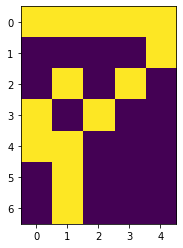

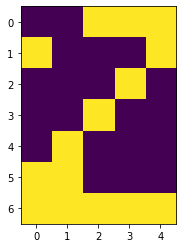

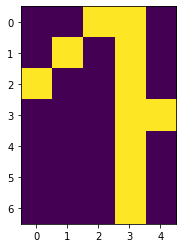

In [2]:
import matplotlib.pyplot as plt

def plot_image(pixels):
    plt.imshow(pixels.reshape((7, 5)))
    plt.show()
    
for i in range(3):
    plot_image(train_data[i])

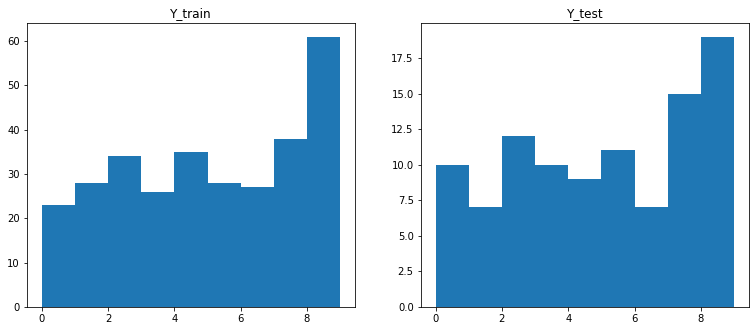

In [9]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot
pyplot.figure(figsize(20, 24))

pyplot.subplot(4, 3, 1)
pyplot.hist(train_labels, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pyplot.title("Y_train")

pyplot.subplot(4, 3, 2)
pyplot.hist(test_labels, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pyplot.title("Y_test")

pyplot.show()

In [3]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels, test_data, test_labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    # estimator = make_pipeline(StandardScaler(), kmeans).fit(data) standardscaler not needed
    estimator = kmeans.fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator.inertia_]
    

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator.labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator.labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]
    
    prediction = estimator.predict(test_data)
    c = prediction == test_labels
    res = 0
    for i in c:
        if i:
           res += 1
    
    results += [
        res / len(prediction)
    ]
    
    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}"
    )
    print(formatter_result.format(*results))

 
 #### Calling fit on the pipeline is the same as calling fit on each estimator in turn, 
 transform the input and pass it on to the next step. The pipeline has all the methods 
 that the last estimator in the pipeline has, i.e. if the last estimator is a classifier, the 
 Pipeline can be used as a classifier. If the last estimator is a transformer, again, so is 
 the pipeline.
 

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(100 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette\tclassic")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=train_data, labels=train_labels, 
              test_data=test_data, test_labels=test_labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=train_data, labels=train_labels, 
              test_data=test_data, test_labels=test_labels)

pca = PCA(n_components=n_digits).fit(train_data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=train_data, labels=train_labels, 
              test_data=test_data, test_labels=test_labels)

print(100 * "_")

____________________________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette	classic
k-means++	0.115s	760	0.939	0.963	0.951	0.876	0.947	0.249		0.160
random   	0.010s	743	0.976	0.976	0.976	0.968	0.974	0.266		0.110
PCA-based	0.003s	764	0.944	0.994	0.968	0.906	0.966	0.251		0.090
____________________________________________________________________________________________________
